# Define packages and hyperparameters

In [1]:
import os
import os.path as osp
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

Y_FEATURE = 'diagnosis'
X_FEATURES = ['radius_mean', 'texture_mean', 'perimeter_mean',
              'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
              'concave points_mean', 'concavity_mean', 'fractal_dimension_mean',
              'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
              'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
              'fractal_dimension_se', 'radius_worst', 'texture_worst',
              'perimeter_worst', 'area_worst', 'smoothness_worst',
              'compactness_worst', 'concavity_worst', 'concave points_worst',
              'symmetry_worst', 'fractal_dimension_worst']
DISTRIBUTION_MODES = ["setting1", "setting2", "setting3"]
STATION_LIST = ["uka", "umg", "ukk", "ukl", "imise", "hsm"]

def fix_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
fix_all_seeds(2021)

from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
!pip install -U kaleido
import kaleido

# Load data from Google drive or download from GitHub



In [2]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = "/content/drive/MyDrive/DSM-AS/input"
OUTPUT_DIR = "/content/drive/MyDrive/DSM-AS/output"
data_df = pd.read_csv(osp.join(BASE_DIR, "data.csv"))
if not osp.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Using t-sne to transform features into 3-D space

In [3]:
X = data_df[X_FEATURES]
tsne = TSNE(n_components=3, random_state=0)
projs = tsne.fit_transform(X, )
proj_cols = ["p1","p2","p3"]
projs = pd.DataFrame(projs, columns=proj_cols)
data_df = pd.concat([data_df, projs], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [4]:
data_df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,p1,p2,p3
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN,-11.026945,-4.468539,5.427923
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN,-9.691925,-5.713438,4.421921
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN,-10.188016,-3.755950,2.246425
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN,2.360013,-5.378951,1.451830
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN,-9.346713,-3.800225,0.701942


In [5]:
eda_df = pd.DataFrame(columns=["id", *proj_cols, "station"])
distribution_mode = "setting3"
for station in STATION_LIST:
    station_df = pd.read_csv(osp.join(BASE_DIR, "{}/{}.csv".format(distribution_mode, station))).rename(columns={"patient_id":"id"})
    station_df["id"] = station_df["id"].map(lambda x: int(x[6:]))
    station_df = pd.merge(data_df[["id", *proj_cols]], station_df, on='id', how='right')
    station_df["station"] = station.upper()
    eda_df = pd.concat([eda_df, station_df])

In [6]:
eda_df.head(5)

,id,p1,p2,p3,station
0,84300903,-10.188016,-3.755950,2.246425,UKA
1,84348301,2.360013,-5.378951,1.451830,UKA
2,84458202,-2.009746,7.505063,-4.134535,UKA
3,844981,2.882082,4.831898,-4.833190,UKA
4,84610002,-9.673441,3.769980,-2.227702,UKA


In [7]:
for i in range(3):
    q_low = eda_df[f"p{i+1}"].quantile(0.01)
    q_hi  = eda_df[f"p{i+1}"].quantile(0.99)
    print(f"p{i+1} outlier range: <{q_low}, >{q_hi}")

p1 outlier range: <-11.073702125549316, >7.7892174339294415
p2 outlier range: <-8.537560739517211, >9.01607580184935
p3 outlier range: <-9.066346130371095, >12.083532485961914


In [8]:
vis_df= pd.merge(eda_df, pd.melt(eda_df, id_vars=['id'], value_vars=["p1","p2","p3"], var_name='dim'), on='id', how='right')
vis_df.head(5)

,id,p1,p2,p3,station,dim,value
0,84300903,-10.188016,-3.755950,2.246425,UKA,p1,-10.188016
1,84348301,2.360013,-5.378951,1.451830,UKA,p1,2.360013
2,84458202,-2.009746,7.505063,-4.134535,UKA,p1,-2.009746
3,844981,2.882082,4.831898,-4.833190,UKA,p1,2.882082
4,84610002,-9.673441,3.769980,-2.227702,UKA,p1,-9.673441


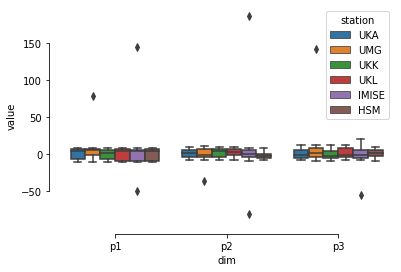

In [9]:
plt.figure()
plt.tight_layout()
sns.boxplot(y="value", x="dim", hue="station", data=vis_df)
sns.despine(offset=10, trim=True)

In [10]:
fig = go.Figure()
fig = px.scatter_3d(
    eda_df, x="p1", y="p2", z="p3",
    color=eda_df.station
)
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[-12,8],),
        yaxis = dict(nticks=4, range=[-15,10],),
        zaxis = dict(nticks=4, range=[-15,13],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))
fig.update_traces(marker_size=3)
fig.show()
# fig.write_image(osp.join(OUTPUT_DIR, "tsne.png"))